##Setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs

In [5]:
from mesoscope.utils import normalize

In [6]:
import thunder

In [7]:
from registration import CrossCorr

##Set directory and session information

In [8]:
directory = '/tier2/freeman/Nick/mVR/sessions'

In [11]:
key = '000134'
prefix = 'trial'
path = directory + '/' + key
print path
print exists(path)

/tier2/freeman/Nick/mVR/sessions/000134
True


##Load data

In [13]:
data = thunder.images.frombinary(path + '/images', engine=sc)

In [14]:
data

Images
mode: spark
dtype: int16
shape: (8585, 4, 512, 512)

##Register data

In [15]:
reference = data[:30].mean().toarray()

In [16]:
algorithm = CrossCorr(axis=0)

In [17]:
model = algorithm.fit(data, reference)

In [18]:
registered = model.transform(data)

In [19]:
registered

Images
mode: spark
dtype: int16
shape: (8585, 4, 512, 512)

##Inspect shifts

In [20]:
shifts = model.toarray()

In [21]:
shifts.shape

(8585, 4, 2)

(0, 1000)

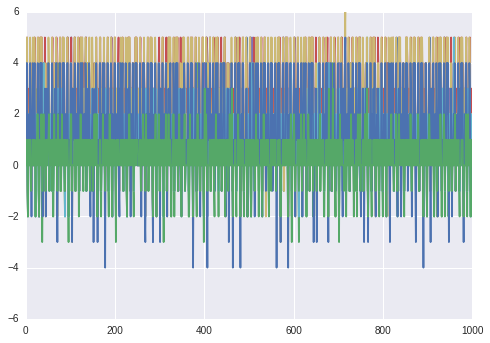

In [22]:
[plt.plot(model.toarray()[:,i]) for i in range(shifts.shape[1])];
plt.xlim([0, 1000])

##Inspect data

In [23]:
mean = registered.mean().toarray()

In [24]:
mean.shape

(4, 512, 512)

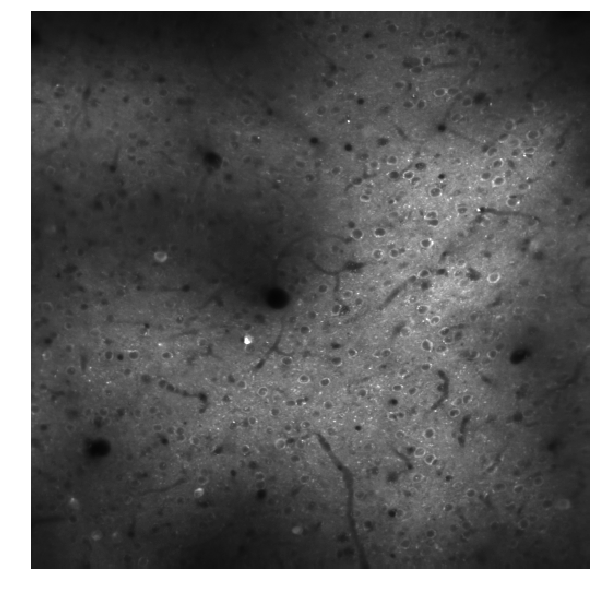

In [25]:
img = mean[0]
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(img, clim=(0, 3.5*img.mean()), ax=ax)

##Save registered binary data

In [26]:
if not exists(path + '/registered'):
    makedirs(path + '/registered')
registered.tobinary(path + '/registered', overwrite=True)

##Save summary data

In [27]:
if not exists(path + '/summary'):
    makedirs(path + '/summary')

###Raw tiffs

In [28]:
from skimage.io import imsave
imsave(path + '/summary/registered.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')
imsave(path + '/summary/reference.tif', reference.astype('float32'), plugin='tifffile', photometric='minisblack')

###Normalized tiffs

In [29]:
imsave(path + '/summary/registered-norm.tif', normalize(mean).astype('float32'), plugin='tifffile', photometric='minisblack')
imsave(path + '/summary/reference-norm.tif', normalize(reference).astype('float32'), plugin='tifffile', photometric='minisblack')